In [1]:
# PROCESS THE GAIA CATALOG OF VARIABLE STARS:
# Gaia has a table for RR Lyrae stars and Cepheid variables
# gaiadr3.vari_rrlyrae & gaiadr3.vari_cepheid
#
#
# ZACK REEVES
# CREATED: 2024
#
# VERSIONS:
#  1.1  MAR 2024 CREATE JUPYTER NOTEBOOK

In [2]:
import pandas as pd
import numpy as np
import sys
import os
import collections

import astropy.units as u
import astropy.coordinates
from astropy.table import Table, join, vstack
from astropy.io import ascii

from astroquery.gaia import Gaia

sys.path.insert(0, '..')
from common import file_functions, calculations

from matplotlib import pyplot as plt, colors

In [3]:
# Define the metadata for the data set.  NEED TO EDIT
#https://www.aanda.org/articles/aa/full_html/2023/06/aa43964-22/aa43964-22.html
metadata = {}

metadata['project'] = 'Digital Universe Atlas Gaia Subsets'
metadata['sub_project'] = 'Cepheid and RRLyrae Variable Stars'

metadata['catalog'] = 'The Gaia Catalogue of Nearby Stars (Gaia Collaboration, 2021)'  #need to edit
metadata['catalog_author'] = 'Gaia Collaboration'
metadata['catalog_year'] = '2021'
metadata['catalog_doi'] = 'doi:10.1051/0004-6361/202039498'
metadata['catalog_bibcode'] = '2021A&A...649A...6G'

metadata['prepared_by'] = 'Brian Abbott, Zack Reeves'
metadata['version'] = '1.1'

metadata['dir'] = metadata['sub_project'].replace(' ', '_').lower()
metadata['raw_data_dir'] = ''

metadata['data_group_title'] = 'CVRRL'
metadata['data_group_desc'] = 'Variable stars in the Milky Way mapped by Gaia'
metadata['data_group_desc_long'] = 'RR Lyrae stars are excellent tracers of the oldest stars (ages ≳ 9–10 Gyr) and standard candles for measuring the distance to stellar systems that are mainly composed of an old stellar population. The Gaia Third Data Release (DR3) publishes a catalogue of full-sky RR Lyrae stars observed during the initial 34 months of science operations. They were processed through the Specific Object Study (SOS) pipeline, which was developed to validate and characterise Cepheids and RR Lyrae stars (SOS Cep&RRL) observed by Gaia.'
metadata['fileroot'] = 'cvrrl'

file_functions.generate_license_file(metadata)

In [4]:
#query cepheid table

#log in to Gaia Server - Can change to different credentials file for a different user
#query runs in less than a minute
#file is small, 15021 objects
Gaia.login(credentials_file='../common/gaia_credentials.txt')

#Query Gaia DR3 **we can add more params later, maybe get metallicity, periods, etc

job = Gaia.launch_job_async("select a.source_id, "
                            "b.ra, b.dec, b.pmra, b.pmdec, b.parallax, b.parallax_error, b.phot_g_mean_mag, b.bp_g, b.radial_velocity, b.radial_velocity_error, b.grvs_mag, b.rv_template_teff, "
                            "bj.r_med_geo, bj.r_hi_geo, bj.r_lo_geo, bj.r_med_photogeo, bj.r_hi_photogeo, bj.r_lo_photogeo "
                            "from gaiadr3.vari_cepheid a inner join gaiadr3.gaia_source b on a.source_id = b.source_id "
                            "left join external.gaiaedr3_distance bj on a.source_id = bj.source_id",
                            dump_to_file=False)

#Put the resulting table into a Table
cepheids = job.get_results()
cepheids['variable_type'] = ['cepheid']*len(cepheids)

Gaia.remove_jobs(job.jobid)

Gaia.logout()

INFO: Login to gaia TAP server [astroquery.gaia.core]
OK
INFO: Login to gaia data server [astroquery.gaia.core]
OK
INFO: Query finished. [astroquery.utils.tap.core]
Removed jobs: '1716663373402O'.
INFO: Gaia TAP server logout OK [astroquery.gaia.core]
INFO: Gaia data server logout OK [astroquery.gaia.core]


In [5]:
#query RR Lyrae table

#log in to Gaia Server - Can change to different credentials file for a different user
#query runs in a few minutes
#file is smallish, 271779 objects
Gaia.login(credentials_file='../common/gaia_credentials.txt')

#Query Gaia DR3 **we can add more params later, maybe get metallicity, periods, etc

job = Gaia.launch_job_async("select a.source_id, "
                            "b.ra, b.dec, b.pmra, b.pmdec, b.parallax, b.parallax_error, b.phot_g_mean_mag, b.bp_g, b.radial_velocity, b.radial_velocity_error, b.grvs_mag, b.rv_template_teff, "
                            "bj.r_med_geo, bj.r_hi_geo, bj.r_lo_geo, bj.r_med_photogeo, bj.r_hi_photogeo, bj.r_lo_photogeo "
                            "from gaiadr3.vari_rrlyrae a inner join gaiadr3.gaia_source b on a.source_id = b.source_id "
                            "left join external.gaiaedr3_distance bj on a.source_id = bj.source_id",
                            dump_to_file=False)

#Put the resulting table into a Table
rrls = job.get_results()
rrls['variable_type'] = ['RRLyrae']*len(rrls)

Gaia.remove_jobs(job.jobid)

Gaia.logout()

INFO: Login to gaia TAP server [astroquery.gaia.core]
OK
INFO: Login to gaia data server [astroquery.gaia.core]
OK
INFO: Query finished. [astroquery.utils.tap.core]
Removed jobs: '1716663389128O'.
INFO: Gaia TAP server logout OK [astroquery.gaia.core]
INFO: Gaia data server logout OK [astroquery.gaia.core]


In [6]:
rrls

SOURCE_ID,ra,dec,pmra,pmdec,parallax,parallax_error,phot_g_mean_mag,bp_g,radial_velocity,radial_velocity_error,grvs_mag,rv_template_teff,r_med_geo,r_hi_geo,r_lo_geo,r_med_photogeo,r_hi_photogeo,r_lo_photogeo,variable_type
,deg,deg,mas / yr,mas / yr,mas,mas,mag,mag,km / s,km / s,mag,K,pc,pc,pc,pc,pc,pc,
int64,float64,float64,float64,float64,float64,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,str7
177571127944832,46.05558586315165,0.9744640130919913,0.12790265127379608,-2.1485194864010615,0.10950912758079706,0.16715279,18.191385,0.27872467,--,--,--,--,3095.6086,4130.5938,2406.691,5663.453,6680.835,4772.949,RRLyrae
288243845193088,44.32290682471504,0.785227574248386,0.29770444976859234,-1.6734125643800264,-0.07509860997433918,0.1853054,18.441326,0.3224373,--,--,--,--,4587.9443,7561.6196,3015.1538,6337.328,7464.6104,5390.5283,RRLyrae
500243431117184,44.69810251269097,1.7456159620866967,0.2026914466430934,-2.031459701292297,0.3273876267624963,0.15893565,18.132149,0.2598877,--,--,--,--,2475.7566,3328.748,1884.7009,6782.233,8710.321,5461.9805,RRLyrae
507222753405440,44.66531451824552,1.7893948656380543,6.025927994649281,-4.524068010482206,0.08783417587724604,0.030122554,14.839219,0.29148006,--,--,--,--,6535.086,7727.076,5562.0073,7115.9497,7813.0674,6467.1685,RRLyrae
584630948352256,46.34146909549162,1.5419978766334914,1.2484969245065645,-1.8692133267396225,-0.017264769068948922,0.08766588,17.433165,0.24014854,--,--,--,--,6116.5757,8194.751,4533.64,6127.0796,7295.2925,5061.367,RRLyrae
782027645388032,46.69911546428052,2.303870870425575,-0.12811239520115078,-2.1270200386868514,-0.020688012057405794,0.13714933,17.988972,0.15971756,--,--,--,--,4064.1104,5353.007,3020.5981,5691.146,6863.152,4691.1157,RRLyrae
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6917321602197087360,313.960968491152,-1.330016011851913,-0.956166142181343,-2.6846649696861373,-0.01637885215099953,0.04562871,15.969347,0.16675186,--,--,--,--,14169.728,18897.008,10162.944,8418.181,10719.995,6651.049,RRLyrae


In [25]:
data = vstack([cepheids, rrls])
data['variable_type'] = data.Column(data['variable_type'],
                            meta=collections.OrderedDict([('ucd', 'meta.vari_type')]),
                            description='Type of Variable Star')
data

SOURCE_ID,ra,dec,pmra,pmdec,parallax,parallax_error,phot_g_mean_mag,bp_g,radial_velocity,radial_velocity_error,grvs_mag,rv_template_teff,r_med_geo,r_hi_geo,r_lo_geo,r_med_photogeo,r_hi_photogeo,r_lo_photogeo,variable_type,dcalc,bj_distance,e_bj_dist,dist_pc,dist_ly,x,y,z,u,v,w,speed,appmag,absmag,lum,color,speck_label,label
,deg,deg,mas / yr,mas / yr,mas,mas,mag,mag,km / s,km / s,mag,K,pc,pc,pc,pc,pc,pc,,,pc,pc,pc,lyr,pc,pc,pc,km / s,km / s,km / s,,mag,mag,solLum,solLum,,
int64,float64,float64,float64,float64,float64,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,str7,int64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float32,float64,float64,float32,str22,str27
4658032774371311104,83.48962697026485,-69.56621810386702,1.6573234905144658,0.5373643081019204,-0.04975604864567314,0.029840274,15.903541,0.4943838,--,--,--,--,17579.615,24944.584,13895.961,10048.599,10698.669,9231.942,cepheid,1,10048.5986328125,733.36328125,10048.598633,32774.1,1489.666662,-8387.762138,-5329.228278,nan,nan,nan,nan,15.903541,0.893013,34.103170,0.49,#__4658032774371311104,GaiaDR3_4658032774371311104
4658035626229427456,83.50979201197948,-69.41232383466917,1.2836830619384996,0.5697417080906918,0.0031852942713621463,0.060265366,16.873093,0.046604156,--,--,--,--,7990.6313,10997.095,6084.4536,6283.3506,8127.648,5050.1035,cepheid,1,6283.3505859375,1538.772216796875,6283.350586,20493.5,914.771633,-5246.940075,-3333.662744,nan,nan,nan,nan,16.873093,2.882136,5.459408,0.05,#__4658035626229427456,GaiaDR3_4658035626229427456
4658036274856153856,83.19749527339663,-69.42498845595979,1.476040496030872,0.6423621663094878,-0.07303912060201159,0.038431942,15.978915,0.28905964,--,--,--,--,14324.097,19461.637,11278.498,17852.197,24229.76,12960.82,cepheid,1,17852.197265625,5634.4697265625,17852.197266,58226.1,2604.533740,-14888.623383,-9499.802365,nan,nan,nan,nan,15.978915,-0.279543,100.419318,0.29,#__4658036274856153856,GaiaDR3_4658036274856153856
4658036828819820800,83.19373243902551,-69.37312762730657,1.5585671158100078,0.5710421227020045,-0.056150722533047204,0.023238804,15.327039,0.29372406,--,--,--,--,23835.756,30618.01,18131.69,29189.15,36260.13,19517.873,cepheid,1,29189.150390625,8371.1279296875,29189.150391,95202.3,4232.456272,-24345.738161,-15536.339589,nan,nan,nan,nan,15.327039,-1.999069,489.358800,0.29,#__4658036828819820800,GaiaDR3_4658036828819820800
4658039710832195200,83.02051676700864,-69.34915060596933,1.6407140422779494,0.5034647434222738,0.08622576238752203,0.029818624,15.92822,0.29041576,--,--,--,--,7754.6553,9781.739,6408.205,5846.383,6471.618,5326.3994,cepheid,1,5846.3828125,572.609375,5846.382812,19068.4,845.627403,-4873.123763,-3117.333970,nan,nan,nan,nan,15.928220,2.093784,11.284611,0.29,#__4658039710832195200,GaiaDR3_4658039710832195200
4658040745829467392,82.89706008824761,-69.31852355759291,1.5820860011620355,0.4792297117215985,-0.006775391502538669,0.018764975,14.83601,0.395051,--,--,--,--,17115.508,21751.055,13333.598,16313.213,20274.842,13173.843,cepheid,1,16313.212890625,3550.49951171875,16313.212891,53206.6,2351.597602,-13591.568792,-8709.773895,nan,nan,nan,nan,14.836010,-1.226688,240.256428,0.40,#__4658040745829467392,GaiaDR3_4658040745829467392
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6917321602197087360,313.960968491152,-1.330016011851913,-0.956166142181343,-2.6846649696861373,-0.01637885215099953,0.04562871,15.969347,0.16675186,--,--,--,--,14169.728,18897.008,10162.944,8418.181,10719.995,6651.049,RRLyrae,1,8418.1806640625,2034.47314453125,8418.180664,27456.4,5065.130860,5435.385792,-3958.130411,nan,nan,nan,nan,15.969347,1.343256,22.526706,0.17,#__6917321602197087360,GaiaDR3_6917321602197087360


In [8]:
#setting dcalc based on r_med_geo (if>500pc and photogeo exists, we choose photogeo and set dcalc to 1, else geo and dcalc to 2)
data['dcalc'] = [1 if((not(np.ma.is_masked(data['r_med_photogeo'][i])))and(data['r_med_geo'][i]>500)) else 2 for i in range(len(data))]

#setting metadata for dcalc
data['dcalc'] = data.Column(data['dcalc'],
                            meta=collections.OrderedDict([('ucd', 'meta.dcalc')]),
                            description='Distance Indicator: 1 indicates a Bailer-Jones photogeometric distance; 2 indicates a Bailer-Jones geometric distance')

#Choosing distance based on dcalc
data['bj_distance'] = [data['r_med_photogeo'][i] if data['dcalc'][i]==1 else data['r_med_geo'][i] for i in range(len(data))]
data['bj_distance'].unit=u.pc

#Choosing and calculating distance error based on the distance we chose
data['e_bj_dist'] = [((data['r_hi_photogeo'][i]-data['r_lo_photogeo'][i])/2)*u.pc if((not(np.ma.is_masked(data['r_med_photogeo'][i])))and(data['r_med_geo'][i]>500)) else ((data['r_hi_geo'][i]-data['r_lo_geo'][i])/2)*u.pc for i in range(len(data))]

In [9]:
#calculating distance in light years and parsecs
calculations.get_distance(data, dist='bj_distance', use='distance')

In [10]:
#calculating cartesian coordinates
calculations.get_cartesian(data, ra='ra', dec='dec', pmra='pmra', pmde='pmdec', radial_velocity='radial_velocity', frame='icrs')

/Users/zackreeves/anaconda3/lib/python3.11/site-packages/astropy/units/quantity.py:666: RuntimeWarning: invalid value encountered in divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/Users/zackreeves/anaconda3/lib/python3.11/site-packages/astropy/units/quantity.py:666: RuntimeWarning: divide by zero encountered in divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)


In [11]:
#calculating absolute magnitudes
#calculate absolute V mag based on apparent magnitude and distance
data['appmag'] = data.MaskedColumn(data=data['phot_g_mean_mag'],
                             unit=u.mag,
                             meta=collections.OrderedDict([('ucd', 'phot.mag;em.opt.G')]),
                             format='{:.6f}',
                             description='Apparent magnitude in Gaia G-band')
data['absmag'] = data.MaskedColumn(data=[data['appmag'][i]+5-5*np.log10(data['dist_pc'][i]) for i in range(len(data))],
                             unit=u.mag,
                             meta=collections.OrderedDict([('ucd', 'phot.magAbs;em.opt.G')]),
                             format='{:.6f}',
                             description='Absolute magnitude in Gaia G-band')

/var/folders/t7/vv1pw8sd6xb5q0z3nsqxmmqm0000gn/T/ipykernel_9256/3740164870.py:8: RuntimeWarning: divide by zero encountered in log10
  data['absmag'] = data.MaskedColumn(data=[data['appmag'][i]+5-5*np.log10(data['dist_pc'][i]) for i in range(len(data))],


In [12]:
#calculate luminosity based on absolute magnitude
data['lum'] = [10**(1.89 - 0.4*data['absmag'][i]) for i in range(len(data))]
small_luminosities = np.where((data['lum']>0.0) & (data['lum']<0.001))[0]
data['lum'][small_luminosities] = [0.001]*len(small_luminosities)

data['lum'] = data.MaskedColumn(data=data['lum'],
                             unit=u.solLum,
                             meta=collections.OrderedDict([('ucd', 'phys.luminosity')]),
                             format='{:.6f}',
                             description='Stellar Luminosity')

(array([1.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
        0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
        0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
        0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
        1.0000e+00, 1.0000e+00, 1.0000e+00, 0.0000e+00, 0.0000e+00,
        0.0000e+00, 0.0000e+00, 1.0000e+00, 0.0000e+00, 1.0000e+00,
        1.0000e+00, 1.0000e+00, 1.0000e+00, 1.0000e+00, 3.0000e+00,
        4.0000e+00, 2.0000e+00, 1.0000e+00, 2.0000e+00, 4.0000e+00,
        5.0000e+00, 4.0000e+00, 6.0000e+00, 5.0000e+00, 4.0000e+00,
        2.0000e+00, 4.0000e+00, 4.0000e+00, 1.1000e+01, 1.0000e+01,
        8.0000e+00, 7.0000e+00, 4.0000e+00, 1.3000e+01, 9.0000e+00,
        1.3000e+01, 1.9000e+01, 1.3000e+01, 2.1000e+01, 1.1000e+01,
        2.2000e+01, 2.1000e+01, 1.3000e+01, 2.0000e+01, 2.7000e+01,
        3.1000e+01, 3.1000e+01, 3.3000e+01, 3.1000e+01, 3.9000e+01,
        3.6000e+01, 4.3000e+01, 3.5000e+01, 4.10

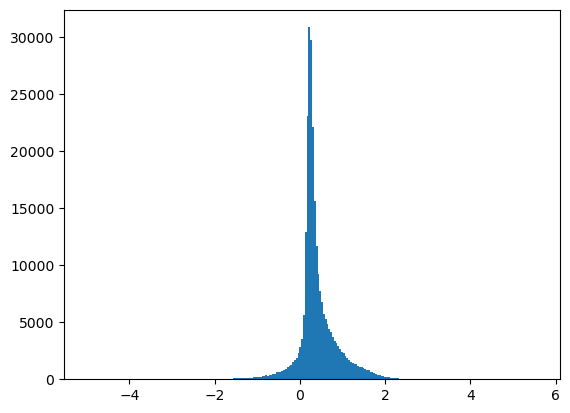

In [13]:
#setting color and visualizing
data['color'] = data.MaskedColumn(data=data['bp_g'],
                             unit=u.solLum,
                             meta=collections.OrderedDict([('ucd', 'phys.color')]),
                             format='{:.2f}',
                             description='Gaia BP-G color')
plt.hist(data['color'], bins=250)

<function matplotlib.pyplot.show(close=None, block=None)>

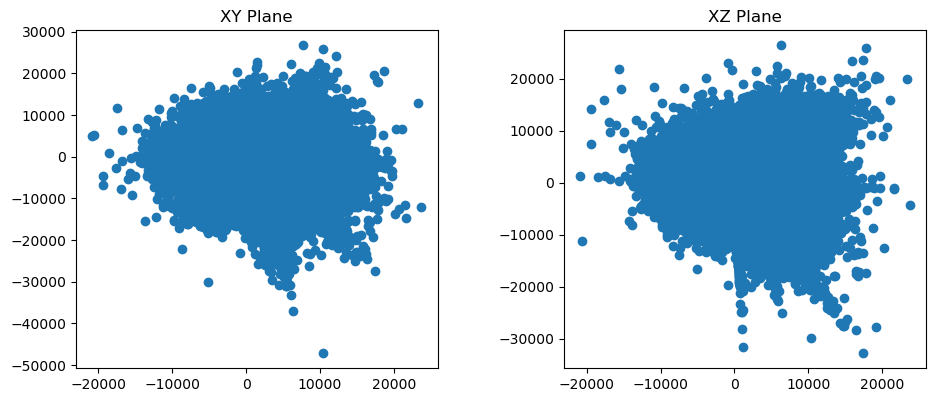

In [14]:
#2D Visualization
fig, ax = plt.subplots(1, 2)

#XY Plane
ax[0].scatter(data['x'], data['y'])
ax[0].set_title('XY Plane')

#XZ Plane
ax[1].scatter(data['x'], data['z'])
ax[1].set_title('XZ Plane')

#set good spacing
fig.tight_layout()
fig.set_size_inches(10, 4, forward=True)
plt.show

<function matplotlib.pyplot.show(close=None, block=None)>

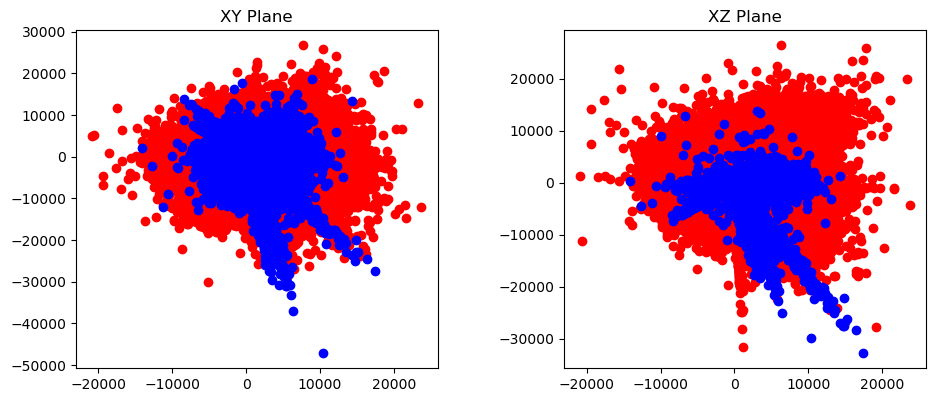

In [20]:
#2D Visualization
fig, ax = plt.subplots(1, 2)

#XY Plane
ax[0].scatter(data[data['variable_type']=='RRLyrae']['x'], data[data['variable_type']=='RRLyrae']['y'], color='red')
ax[0].scatter(data[data['variable_type']=='cepheid']['x'], data[data['variable_type']=='cepheid']['y'], color='blue')

ax[0].set_title('XY Plane')

#XZ Plane
ax[1].scatter(data[data['variable_type']=='RRLyrae']['x'], data[data['variable_type']=='RRLyrae']['z'], color='red')
ax[1].scatter(data[data['variable_type']=='cepheid']['x'], data[data['variable_type']=='cepheid']['z'], color='blue')
ax[1].set_title('XZ Plane')

#set good spacing
fig.tight_layout()
fig.set_size_inches(10, 4, forward=True)
plt.show

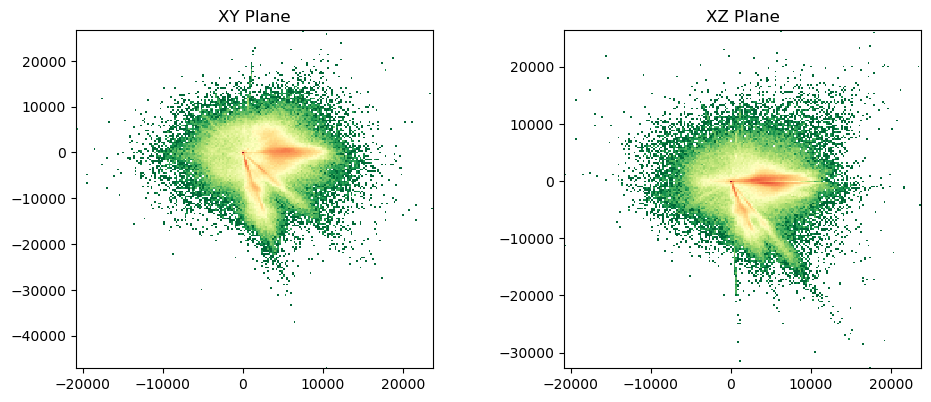

In [21]:
#2D Density Visualization
fig, ax = plt.subplots(1, 2)

#XY Plane
ax[0].hist2d(data['x'], data['y'], 
           bins = 200,  
           norm = colors.LogNorm(),  
           cmap = "RdYlGn_r",) 
ax[0].set_title('XY Plane')

#XZ Plane
ax[1].hist2d(data['x'], data['z'], 
           bins = 200,  
           norm = colors.LogNorm(),  
           cmap = "RdYlGn_r",) 
ax[1].set_title('XZ Plane')

#set good spacing
fig.tight_layout()
fig.set_size_inches(10, 4, forward=True)
#plt.show

In [24]:
#construct a speck comment column
data['speck_label'] = data.Column(data=['#__'+str(name) for name in data['SOURCE_ID']], 
                                  meta=collections.OrderedDict([('ucd', 'meta.id')]),
                                  description='Gaia DR3 Source ID')

#construct a label column
data['label'] = ['GaiaDR3_'+ str(source) for source in data['SOURCE_ID']]  #leaving for now in case we want to add other labels

In [26]:
#setting texture number column
data['texnum'] = data.Column(data=[1]*len(data), 
                                  meta=collections.OrderedDict([('ucd', 'meta.texnum')]),
                                  description='Texture Number')

In [27]:
#Getting the column metadata
columns = file_functions.get_metadata(data, columns=['x', 'y', 'z', 'color', 'lum', 'absmag', 'appmag', 'texnum', 'dist_ly', 'dcalc', 'u', 'v', 'w', 'speed', 'variable_type', 'speck_label'])
columns

,name,unit,datatype,width,precision,arraysize,ucd,description
0,x,pc,float64,,6,,pos.cartesian.x,Position (x coordinate) in pc
1,y,pc,float64,,6,,pos.cartesian.y,Position (y coordinate) in pc
2,z,pc,float64,,6,,pos.cartesian.z,Position (z coordinate) in pc
3,color,solLum,float32,,2,,phys.color,Gaia BP-G color
4,lum,solLum,float64,,6,,phys.luminosity,Stellar Luminosity
5,absmag,mag,float64,,6,,phot.magAbs;em.opt.G,Absolute magnitude in Gaia G-band
6,appmag,mag,float32,,6,,phot.mag;em.opt.G,Apparent magnitude in Gaia G-band
7,texnum,,int64,,,,meta.texnum,Texture Number
8,dist_ly,lyr,float64,,1,,pos.distance,Distance from Sun (lyr)
9,dcalc,,int64,,,,meta.dcalc,Distance Indicator: 1 indicates a Bailer-Jones...


In [28]:
# Print the csv file using the to_csv function in file_functions
file_functions.to_csv(metadata, Table.to_pandas(data), columns)

In [29]:
# Print the speck file using the to_speck function in file_functions
file_functions.to_speck(metadata, Table.to_pandas(data), columns)

In [30]:
# Print the label file using the to_label function in file_functions
file_functions.to_label(metadata, Table.to_pandas(data))